In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

# Read data
df = pd.read_csv('data.csv')
# 쓸데없는 index 제거
df = df.drop(df.columns[0], axis=1)
#print(df.head())

train_hours = pd.to_datetime(df['_time'])
#print(train_hours.tail(15))

# moduleName = cosmos만 고르기
cosmos_df = df[df['chainName'] == "cosmos"]
columns_to_keep = ['_time', 'price', 'DokiaCapital #02 (Validator)-amountValue', 'DokiaCapital #01 (Validator)-amountValue']
cosmos_df = cosmos_df[columns_to_keep]
print(cosmos_df.shape)
# (2446, 5)

(2446, 4)


In [67]:
# Plot 'price' over '_time'
plt.figure(figsize=(15, 6))
plt.plot_date(cosmos_df['_time'], cosmos_df['price'], linestyle='solid', marker=None)
plt.title('Price over time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

/var/folders/rs/451vhmx909jbf4784zj52l980000gn/T/ipykernel_50594/863480140.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(cosmos_df['_time'], cosmos_df['price'], linestyle='solid', marker=None)


KeyboardInterrupt: 

In [68]:
# data normalizing
cols = list(cosmos_df)[1:cosmos_df.shape[1]]
print(cols)
print(cosmos_df.shape)
#(2446, 5)

df_for_training = cosmos_df[cols].astype(float)
print(df_for_training.shape)
#(2446, 4)

scaler = MaxAbsScaler()
scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
print(df_for_training_scaled.shape)
#(2446, 4)

['price', 'DokiaCapital #02 (Validator)-amountValue', 'DokiaCapital #01 (Validator)-amountValue']
(2446, 4)
(2446, 3)
(2446, 3)


In [69]:
trainX = []
trainY = []

n_future = 1
n_past = 24 # 24시간

for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
# (2422, 24, 4)
print('trainY shape == {}.'.format(trainY.shape))
# (2422, 1)
# ...

trainX shape == (2422, 24, 3).
trainY shape == (2422, 1).


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 24, 64)            17408     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29857 (116.63 KB)
Trainable params: 29857 (116.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/101
81/81 [==============================] - 2s 15ms/step - loss: 0.0868 - val_loss: 0.0017
Epoch 2/101
81/81 [=============================

INFO:tensorflow:Assets written to: ./models/my_model-6/assets


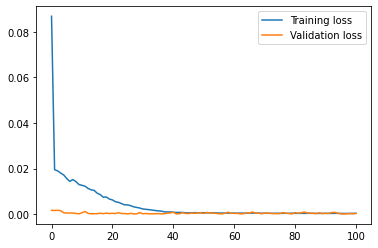

In [70]:
## 여기 shape 수정해야될 거 같은데.
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

# fit the model
history = model.fit(trainX, trainY, epochs=101, batch_size=24, validation_split=0.2, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

# save the model to disk
model.save('./models/my_model-6')

76/76 [==============================] - 0s 4ms/step


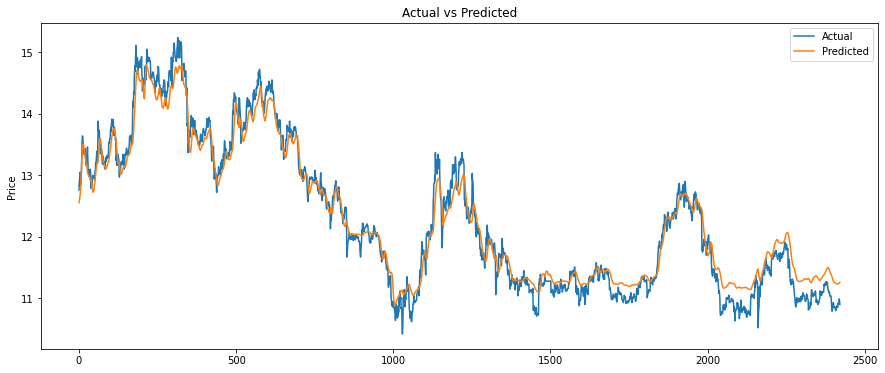

Train Score: 0.23 RMSE


In [72]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# load the model from disk
model = load_model('./models/my_model-6')

def evaluate_model(model, X, y_true, scaler, df_for_training):
    # Predict
    y_pred = model.predict(X)
    
    # Create dummy arrays for inverse transform
    dummy_pred = np.zeros((len(y_pred), df_for_training.shape[1]))
    dummy_true = np.zeros((len(y_true), df_for_training.shape[1]))
    
    # Replace the first column with predicted and actual values
    dummy_pred[:,0] = y_pred[:,0]
    dummy_true[:,0] = y_true[:,0]
    
    # Inverse transform
    y_pred_rescaled = scaler.inverse_transform(dummy_pred)[:,0]
    y_true_rescaled = scaler.inverse_transform(dummy_true)[:,0]
    
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(y_true_rescaled, y_pred_rescaled))
    
    # Plot actual vs predicted values
    plt.figure(figsize=(15, 6))
    plt.plot(y_true_rescaled, label='Actual')
    plt.plot(y_pred_rescaled, label='Predicted')
    plt.title('Actual vs Predicted')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    
    return rmse

# Call the function
trainScore = evaluate_model(model, trainX, trainY, scaler, df_for_training)
print('Train Score: %.2f RMSE' % (trainScore))

# If you also have a test dataset, you can do:
# testPredict = model.predict(testX)
# testPredict = scaler.inverse_transform(testPredict)
# testY_true = scaler.inverse_transform(testY)
# testScore = sqrt(mean_squared_error(testY_true, testPredict))
# print('Test Score: %.2f RMSE' % (testScore)) 


In [7]:
model = load_model('./models/my_model')

# Forecasting...
n_past = 24
n_hours_for_prediction = 1 # predict past 12 hours?
#print(train_hours.tail(24))
forecast_period_hours = pd.date_range(list(train_hours)[-n_past], periods=n_hours_for_prediction, freq='1H').tolist()

forecast = model.predict(trainX[-n_hours_for_prediction:])

prediction_copies = np.repeat(forecast, df_for_training_scaled.shape[1], axis=-1)
print('prediction_copies ', prediction_copies)
# prediction_copies  [[0.72134334 0.72134334 0.72134334 0.72134334]]
y_pred_future = scaler.inverse_transform(prediction_copies)[:, 0]
print('y_pred_future ', y_pred_future)
# y_pred_future  [10.993273]

1/1 [==============================] - 0s 174ms/step
prediction_copies  [[0.72252935 0.72252935 0.72252935]]
y_pred_future  [11.011348]


(1, 2)
           _time      price
0  2023-05-07 03  10.993273
(2446, 2)
(2446, 2)
float64
float32


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

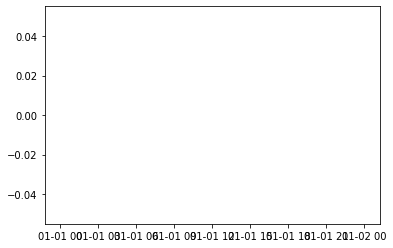

In [151]:
from datetime import datetime

forecast_hours = []
for time_i in forecast_period_hours:
    forecast_hours.append(time_i.strftime('%Y-%m-%d %H'))

df_forecast = pd.DataFrame({'_time': np.array(forecast_hours), 'price': y_pred_future})
print(df_forecast.shape)
print(df_forecast.head())
# (1, 2)
df_forecast['_time'] = pd.to_datetime(df_forecast['_time'])

original = cosmos_df[['_time', 'price']]
print(original.shape)
# (2446, 2)
# print(original.tail())
# 2023-05-8 02:00:00+00:00  10.993273
original.loc[:,('_time')] = pd.to_datetime(original['_time'])
original = original.loc[original['_time'] >= pd.Timestamp("2023-01-24 21:00:00+00:00")]
print(original.shape)
# (2446, 2)

print(original['price'].dtype)
print(df_forecast['price'].dtype)
original['price'] = original['price'].astype(float)
df_forecast['price'] = df_forecast['price'].astype(float)

sns.lineplot(data=original, x="_time", y="price")
sns.lineplot(data=df_forecast, x="_time", y="price")